# Defines and general functions

In [1]:
import os
import time
import sys
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt


def print_status(message : str):
    print("[Status]: ",message)

def print_info(message : str):
    print("[Info]: ",message)

2023-12-16 16:52:03.933016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 16:52:04.003349: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 16:52:04.004539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 16:52:05.138211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/frank/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining and loading the dataset

[Status]:  Defining dataset directory
[Info]:  dataset_dir set to: /home/frank/Documents/Git/Final_Embbeded_Group6/CNN/src/getimages/imgs
[Info]:  num of images: 938
[Status]:  Loading dataset images
[Info]:  Images have dims: [120, 160]
[Status]:  Creating dataset from images
Found 938 files belonging to 4 classes.
Using 751 files for training.
Found 938 files belonging to 4 classes.
Using 187 files for validation.
[Info]:  Class names found: ['cross', 'flat', 'penta', 'square']
[Status]:  Visualizing dataset


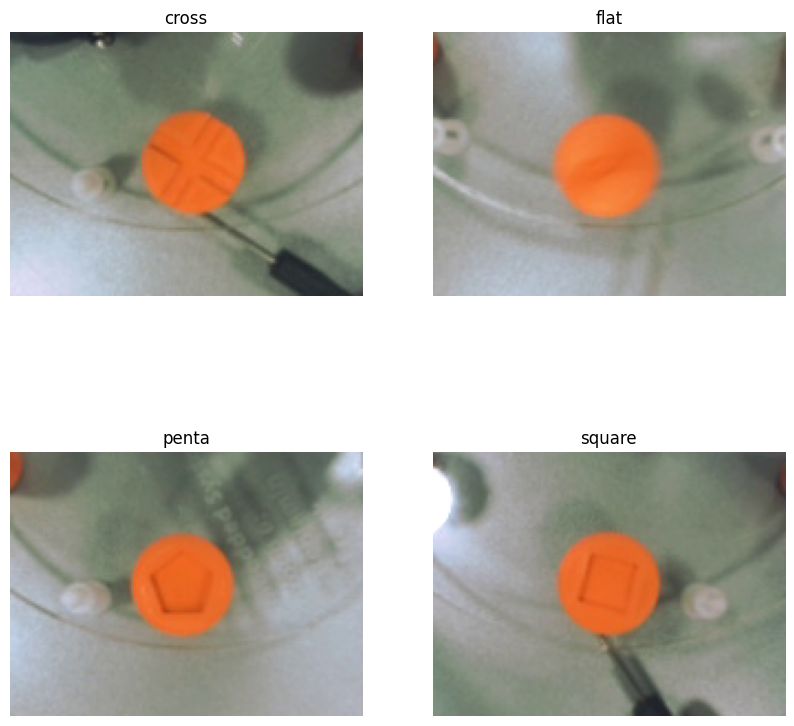

[Info]:  One traning data batch has image shape (32, 120, 160, 3)
[Info]:  One traning data batch has label shape (32,)


In [22]:
print_status("Defining dataset directory")
args = sys.argv[1:]
USE_DEFAULT_IMAGEPATH = True
if USE_DEFAULT_IMAGEPATH:
    dataset_dir = "/home/frank/Documents/Git/Final_Embbeded_Group6/CNN/src/getimages/imgs"
else:
    if len(args) == 2 and args[0] == '-image_path':
        dataset_dir = str(args[1])	
    else:
        dataset_dir = input("Write path to images:")
print_info(f"dataset_dir set to: {dataset_dir}")
data_dir = pathlib.Path(dataset_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print_info(f"num of images: {image_count}")

print_status("Loading dataset images")

image_types = ["cross", "flat", "penta", "square"]
image_files = {}
image_dims = []
for type in image_types:
    image_files[type] = list(data_dir.glob(type + '/*'))
for type in image_types:
    image = PIL.Image.open(str(image_files[type][0]))
    if image_dims != []:
        assert [image.height, image.width] == image_dims, f"Image types does not have the same dimensions!\n {type} has {[image.height, image.width]}, others have {image_dims}"
    else:
        image_dims = [image.height, image.width] 
    # image.show()

# input("Press the <ENTER> key to continue...")

print_info(f"Images have dims: {image_dims}")
print_status("Creating dataset from images")

batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=image_dims,
batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=image_dims,
batch_size=batch_size)

class_names = train_ds.class_names
print_info(f"Class names found: {class_names}")

print_status("Visualizing dataset")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # print(labels)
    used = []
    subplot_dims = int(np.ceil(np.sqrt(len(class_names))))
    for i, label in enumerate(labels[:-1]):
        # print(i, labels[i].numpy().astype("uint8"))
        if labels[i].numpy().astype("uint8") not in used:
            ax = plt.subplot(subplot_dims, subplot_dims, labels[i].numpy().astype("uint8") + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            used.append(labels[i].numpy().astype("uint8"))
plt.show()


for image_batch, labels_batch in train_ds:
    print_info(f"One traning data batch has image shape {image_batch.shape}")
    print_info(f"One traning data batch has label shape {labels_batch.shape}")
    break


# Optimization of dataset

In [23]:

print_status("Normalizing RGB values from [0, 255] to [0, 1]")
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print_info(f"Example result: {np.min(first_image), np.max(first_image)}")

print_status("Enabling caching and prefetching of dataset for traning and validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

[Status]:  Normalizing RGB values from [0, 255] to [0, 1]
[Info]:  Example result: (0.078431375, 0.9803922)
[Status]:  Enabling caching and prefetching of dataset for traning and validation


# Either load or create model

In [24]:
LOAD_EXISTING_MODEL = False

## Create model

### Model definition

In [26]:
if not LOAD_EXISTING_MODEL:
    print_status("Defining model")

    num_classes = len(class_names)

    model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ])

    print_status("Configuring model")

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

[Status]:  Defining model
[Status]:  Configuring model


### Model fitting

In [27]:
if not LOAD_EXISTING_MODEL:
    print_status("Fitting model")

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=3
    )


    # input("Press the <ENTER> key to close the program...")


[Status]:  Fitting model
Epoch 1/3
24/24 [==============================] - 16s 571ms/step - loss: 1.3315 - accuracy: 0.3728 - val_loss: 1.2148 - val_accuracy: 0.2995
Epoch 2/3
24/24 [==============================] - 12s 503ms/step - loss: 0.7663 - accuracy: 0.6764 - val_loss: 0.1821 - val_accuracy: 0.9893
Epoch 3/3
24/24 [==============================] - 11s 448ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 8.6465e-04 - val_accuracy: 1.0000


### Summarise model

In [28]:
if not LOAD_EXISTING_MODEL:
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 120, 160, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 158, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 59, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 77, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 36, 32)       

## Load model

In [29]:
if LOAD_EXISTING_MODEL:
    new_model = tf.keras.models.load_model('my_model.keras')

    # Show the model architecture
    new_model.summary()

In [30]:
# Evaluate the restored model
if LOAD_EXISTING_MODEL:
    loss, acc = new_model.evaluate(val_ds, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(new_model.predict(val_ds).shape)

### Set model to loaded model

In [31]:
if LOAD_EXISTING_MODEL:
    model = new_model

# Evaluating model

In [32]:
print_status("Evaluating model")
train_loss, train_acc = model.evaluate(train_ds, verbose=2)

print_info(f"Accuracy on training data: {train_acc}")

val_loss, val_acc = model.evaluate(val_ds, verbose=2)

print_info(f"Accuracy on validation data: {val_acc}")

[Status]:  Evaluating model


24/24 - 3s - loss: 7.4442e-04 - accuracy: 1.0000 - 3s/epoch - 119ms/step
[Info]:  Accuracy on training data: 1.0
6/6 - 1s - loss: 8.6465e-04 - accuracy: 1.0000 - 613ms/epoch - 102ms/step
[Info]:  Accuracy on validation data: 1.0


# Testing inference

In [33]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)
predictions.shape

6/6 [==============================] - 1s 137ms/step


(187, 4)

In [34]:
predictions[0]
prediction_class = np.argmax(predictions[0])
class_names[prediction_class]

'penta'

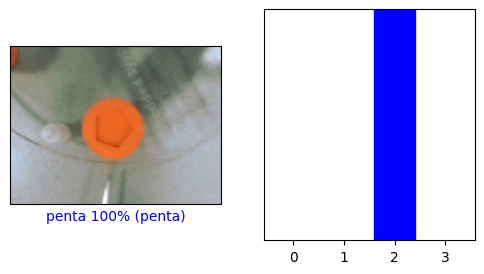

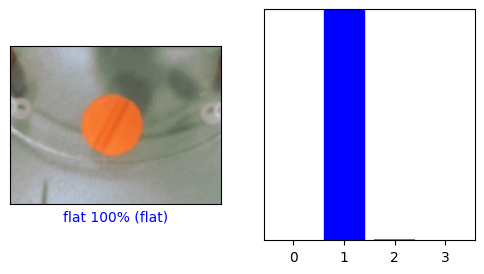

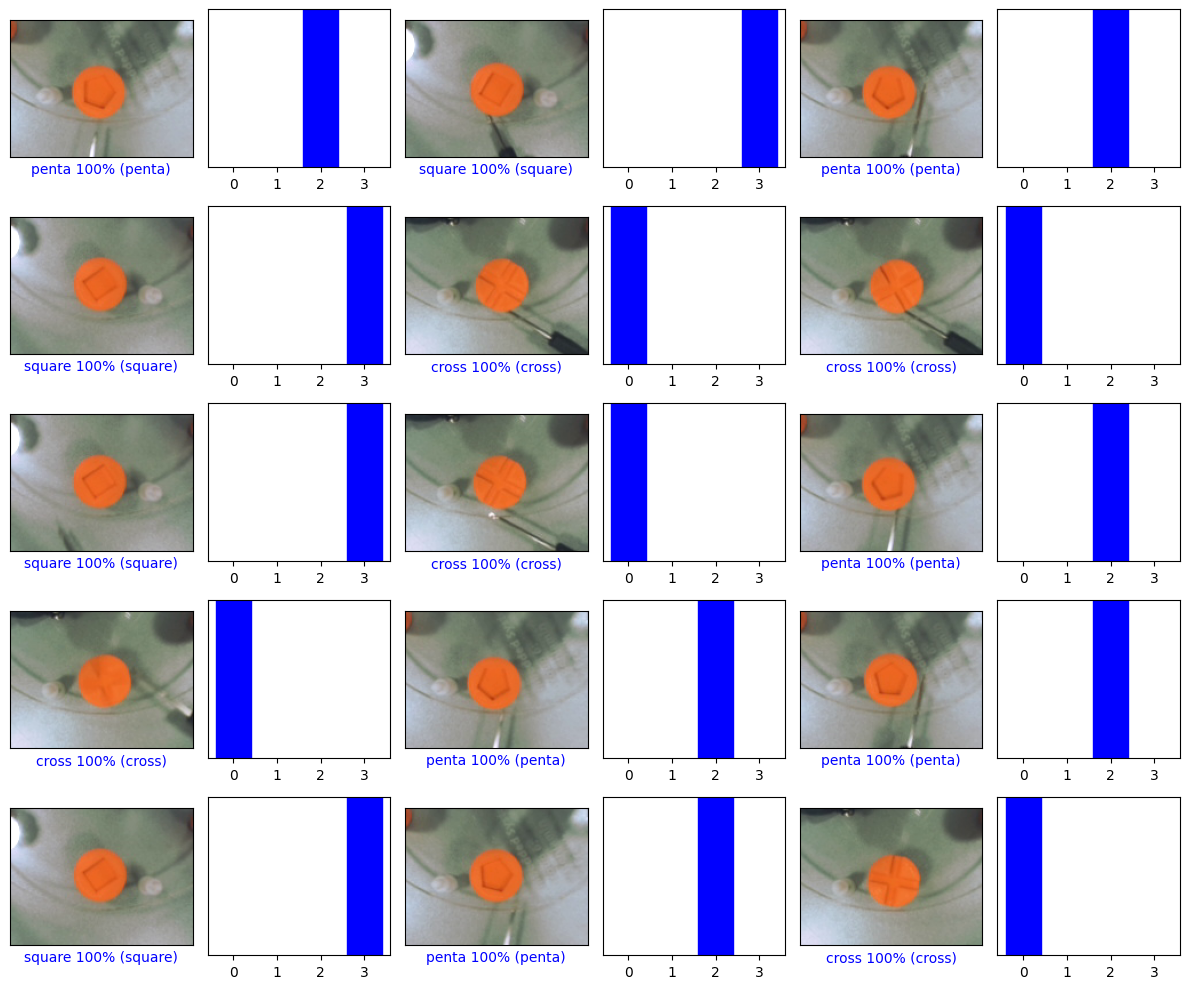

In [35]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

image_array = []
label_array = []
for images, labels in val_ds.take(1):
   for i, image in enumerate(images):
      image_array.append(images[i].numpy().astype("uint8"))
      label_array.append(labels[i])

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_array, image_array)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_array)
plt.show()

i = 20
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_array, image_array)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_array)
plt.show()

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], label_array, image_array)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], label_array)
plt.tight_layout()
plt.show()


# Save model

In [36]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

# Export weights

In [37]:
# np.savetxt("weights.txt", model.layers[1].weights[0].numpy(), delimiter=",")
# np.save("weights", model.layers[1].weights[0].numpy())
for i, layer in enumerate(model.layers[1:]):
    #print(i+1, len(model.layers[1:]))
    test = layer.weights
    print(len(test))

# file = open("weights", "a") 
# for w in range(1, len(model.layers)):
# 	if w == 1:
# 		varName = "#define layer1 const ap_fixed<32,24> layer1_weights[n_inputs][n_layer1]"
# 	else:
# 		varName = "#define layer" + str(w) + " const ap_fixed<32,24> layer" + str(w) + "_weights[n_layer" + str(w-1) + "][n_layer" + str(w) + "]"
# 	file.write(varName + " = ")
# 	file.write('{')
# 	print(len(model.layers), w)
# 	weights = model.layers[w].weights[0].numpy()
# 	for i in range(weights.shape[0]):
# 		file.write('{')
# 		for j in range(weights.shape[1]):
# 			file.write(str(weights[i][j]))
# 			if j != weights.shape[1]-1:
# 				file.write(', ')
# 		file.write('}')
# 		if i != weights.shape[0]-1:
# 			file.write(', ')
# 	file.write('};\n\n')

# file.close()

2
0
2
0
2
0
2
0
0
2
2
2
